# Machine Learning - Onderwijsdagen

Tijdens het praktische gedeelte van deze sessie gaan we aan de slag met Jupyter notebooks. Een notebook is een gebruiksvriendelijke manier om code te schrijven in de programmeertaal Python. De indeling van de notebooks werkt als volgt:

- Elke rechthoekige '__cel__' in de notebook bevat een toelichting ('__Markdown__', net zoals deze cel) of Python-commando's ('__Code__'). Selecteer een cel door er 1 keer op te klikken.


- Door op de knop '__Run__' te klikken, wordt de huidige cel uitgevoerd en de volgende cel automatisch geselecteerd. Wanneer een cel commando's bevat, worden de resultaten hiervan na uitvoer onder de cel weergegeven.


Probeer op deze wijze door het notebook heen te werken. Laat je niet afschrikken door de code, in principe is alles al ingevuld. 
###### Let op: wanneer er iets fout gaat en je de notebook wilt herstarten, dien je weer bovenaan te beginnen!

Doel van deze notebook is het trainen van 10 __perceptrons__. Kort gezegd is een perceptron een simpel neuraal netwerk, bestaande uit een $X$ aantal __inputs__. Alle inputs zijn verbonden met een __output__. De verbindingen tussen $X$ en deze outputs, die de __gewichten__ heten, worden getraind om te zorgen dat de juiste output wordt geactiveerd wanneer de input bepaalde patronen bevat.

Tijdens dit experiment trainen we 10 perceptrons tegelijkertijd op dezelfde invoer, met als doel __automatisch handgeschreven nummers te herkennen__ ('0' tot '9'). Elke perceptron krijgt als taak om een van de getallen te herkennen; afhankelijk van hoe 'sterk' het netwerk een getal denkt te herkennen wordt de perceptron van het respectievelijke getal geactiveerd. Elke output genereert op deze manier een 'kans'-waarde, hoe hoger deze waarde, hoe zekerder het netwerk is van zijn classificatie. Bij een slordig geschreven 8 kan het zijn dat het netwerk zowel een 3 en een 8 als output herkent. De output met de hoogste waarde is de uiteindelijke classificatie van de input.

<img src="images/Perceptron2.png" alt="Perceptron visualization" style="width: 400px;"/>

>_Illustratie van de 10 perceptrons._

Laten we starten met het importeren van de vereiste plugins. Voer de cel uit, en controleer of er een boodschap onder de cel verschijnt.

In [2]:
import os, cv2, keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import models
from keras import layers
from keras.utils import to_categorical
keras.initializers.RandomNormal(seed=42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
print("Klaar!")

Klaar!


We gaan de perceptrons trainen op de breed toegepaste __MNIST-dataset__, die tienduizenden afbeeldingen van handgeschreven nummers bevat. Elke plaatje bestaat uit een zwart-wit nummer met een resolutie van 28 x 28 pixels. Ieder plaatje is van een label voorzien, en op die manier toegewezen aan een van de 10 categorieen ('0', '1', .... '9').

Om de plaatjes te kunnen verwerken in het neurale netwerk, worden ze '__platgeslagen__'. De afbeelding van 28 x 28 pixels wordt omgezet naar een rij van 28*28=784 getallen. De $X$-waarde van ons neurale netwerk is dus 784 inputs, gelijk aan de hoeveelheid pixels die het plaatje bevat.

<img src="images/Perceptron-MNIST.png" alt="Perceptron visualization 2" style="width: 500px;"/>

>_Verwerking van een plaatje in het neurale netwerk._

De MNIST-dataset bestaat uit een __training- en test-dataset__. Een vuistregel voor experimenten met neurale netwerken is om een deel van de beschikbare data apart te zetten in een test-dataset, geschikt voor validatiedoeleinden. Op deze manier kunnen we de nauwkeurigheid van ons neurale netwerk bij gebruik van nieuwe data valideren. Uiteraard zijn alletwee de datasets ook van een lijst met corresponderende __labels__ voorzien.

In [3]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('MNIST data is geimporteerd.')

MNIST data is geimporteerd.


De perceptrons worden straks getraind op de plaatjes uit de __training-dataset__, door ze samen met de __training-labels__ door het neurale netwerk te laten verwerken. 

Laten we bekijken hoe de training-dataset in elkaar zit. Als het goed is laat de code hieronder zien dat er __60.000 plaatjes__ in de dataset zitten, met een resolutie van __28 x 28 pixels__.

In [4]:
train_images.shape

(60000, 28, 28)

Klopt helemaal! Laten we eens kijken hoe de __eerste 8 plaatjes__ uit de dataset eruit zien.

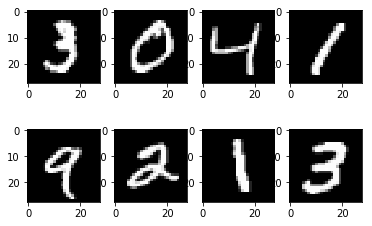

In [5]:
plt.subplot(241)
plt.imshow(train_images[10].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(242)
plt.imshow(train_images[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(243)
plt.imshow(train_images[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(244)
plt.imshow(train_images[3].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(245)
plt.imshow(train_images[4].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(246)
plt.imshow(train_images[5].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(247)
plt.imshow(train_images[6].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(248)
plt.imshow(train_images[7].reshape(28,28), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

Dat ziet er goed uit. We hebben natuurlijk ook de __labels__ bij de plaatjes nodig. Het aantal labels zou gelijk moeten zijn aan het aantal plaatjes (__60.000__).

In [6]:
len(train_labels)

60000

Hoeveel __unieke labels__ zijn er? Dit zouden er '0' tot '9' moeten zijn.

In [7]:
print(np.unique(train_labels))

[0 1 2 3 4 5 6 7 8 9]


Zijn de labels (ongeveer) __gebalanceerd__? Klopt het dat er ongeveer evenveel plaatjes per categorie in de training-dataset zitten?

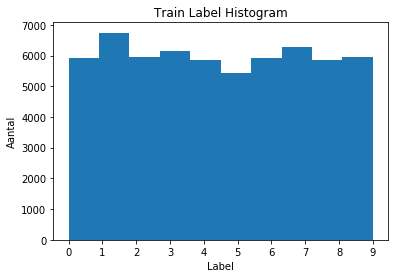

In [8]:
plt.hist(train_labels)

plt.title("Train Label Histogram")
plt.xlabel("Label")
plt.ylabel("Aantal")
plt.xticks(np.arange(10))
fig = plt.gcf()

We kunnen hetzelfde doen voor de __test-dataset__. Deze zou uit 10.000 plaatjes moeten bestaan.

In [9]:
test_images.shape

(10000, 28, 28)

Met 10.000 __labels__...

In [10]:
len(test_labels)

10000

En dezelfde __unieke labels__ ('0' tot '9')...

In [11]:
print(np.unique(test_labels))

[0 1 2 3 4 5 6 7 8 9]


Met een (min of meer) __gelijke verdeling__.

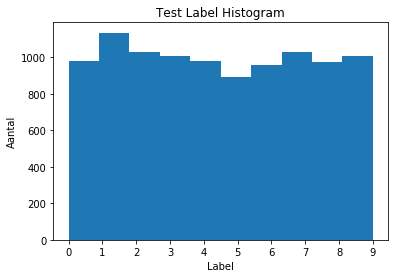

In [12]:
plt.hist(test_labels)

plt.title("Test Label Histogram")
plt.xlabel("Label")
plt.ylabel("Aantal")
plt.xticks(np.arange(10))
fig = plt.gcf()

__=====================================================================================================================__
<b><center>Pauzeer Hier</center></b>
__=====================================================================================================================__

Ieder neuraal netwerk is opgebouwd uit __lagen__, een onderdeel dat je zou kunnen beschouwen als een filter voor de data. Er wordt data ingevoerd, deze wordt verwerkt, en vervolgens uitgevoerd in een voor het netwerk bruikbare vorm.

De lagen filteren __representaties__ uit uit de ingevoerde data -- hopenlijk representaties die kunnen helpen bij het oplossen van ons probleem (het herkennen van handgeschreven nummers).

Het grootste deel van deep learning bestaat uit het bouwen van neurale netwerken, die bestaan uit vele varianten van deze lagen. De netwerken voeren een soort '__data-destillatie__' uit, door keer op keer relevante representaties uit de data te filteren.

Laten we beginnen met het bouwen van ons eigen neurale netwerk! Ons netwerk bestaat uit:

- Een __invoerlaag__ met 28*28=784 inputs (elke pixel uit een plaatje is een input).


- Een __uitvoerlaag__ met 10 outputs, voor elk getal een enkele output ('0', '1', .... '9'). De output met de hoogste waarde is de classificatie van het netwerk.

In [14]:
network = models.Sequential()
network.add(layers.Dense(10, use_bias='true', activation='softmax', input_shape=(28 * 28,)))

print('Lagen toegevoed.')

Lagen toegevoed.


De lagen zijn nu toegevoegd, maar we zijn er nog niet. Om het neurale netwerk klaar te maken voor gebruik moeten er nog 3 zaken geregeld worden, voordat het netwerk kan worden __samengesteld__.

* Een __loss-functie__: deze zorgt ervoor dat het netwerk een idee heeft van hoe goed of slecht het scoort op de training-dataset. Op deze manier kan het netwerk zichzelf bijsturen.


* De __optimizer__: dit mechanisme zorgt ervoor dat het netwerk zichzelf kan bijwerken op basis van de ingevoerde data en de loss-functie.


* De waarden die bijgehouden gaan worden tijdens het trainen en testen. In dit geval houden we alleen rekening met de __nauwkeurigheid (accuracy)__ van het netwerk, bestaande uit het aantal plaatjes dat correct is geclassificeerd.

In [15]:
keras.optimizers.SGD(lr=0.01)

network.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print('Netwerk samengesteld.')

Netwerk samengesteld.


Voordat het daadwerkelijke trainen van het netwerk kan beginnen, moet de data __omgevormd__ worden naar een formaat dat het neurale netwerk verwacht. Alle plaatjes worden __'platgeslagen'__ naar een lijst van 784 cijfers.

In [16]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print('Data-verwerking afgerond.')

Data-verwerking afgerond.


Het trainen van het netwerk gaat als volgt in zijn werk:

- Eerst voeren we de __training dataset__ in binnen het neurale netwerk (`train_images` en de bijbehorende `train_labels`). De perceptrons in het neurale netwerk leren op die manier via de __gewichten__ een associatie aan tussen de plaatjes en de labels. 


- Daarna passen we de __test-dataset__ op het netwerk toe, door de `test_images` in het netwerk te laten verwerken. Dan __verifieren__ we of de voorspellingen uit het netwerk overeenkomen met de labels uit `test_labels`.

Het __trainen__ wordt gestart door de `fit`-functie van het netwerk aan te roepen. Het aantal `epochs` staat voor het aantal keer dat het netwerk door de training-dataset itereert. De `batch_size` geeft aan hoeveel groepen van plaatjes uit de dataset door het netwerk worden gebruikt om zichzelf bij te sturen. Hoe hoger de batch size, hoe sneller het netwerk is met trainen, maar daardoor gaat de nauwkeurigheid ook omlaag.

>_Extra: Experimenteer met verschillende waarden voor de batch size en het aantal epochs, om te zien op welke manier de nauwkeurigheid van het netwerk wordt beinvloed._

In [17]:
network.fit(train_images, train_labels, epochs=20, batch_size=20)

Epoch 1/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.6655 - acc: 0.8383: 1s - loss: 1.0217 - ac - ETA: 1s - loss: 
Epoch 2/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.4099 - acc: 0.8888: 0s - loss: 0.4181 - acc: 0.886 - ETA: 0s - loss: 0.4170 - ac
Epoch 3/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.3691 - acc: 0.8973
Epoch 4/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.3484 - acc: 0.9030
Epoch 5/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.3350 - acc: 0.9065
Epoch 6/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.3255 - acc: 0.9093
Epoch 7/20
60000/60000 [==============================] - 2s 34us/step - loss: 0.3182 - acc: 0.9115
Epoch 8/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.3124 - acc: 0.9135
Epoch 9/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.3078 - acc: 0.

Tijdens het trainen worden er twee getallen weergegeven: de `loss` van het netwerk over de training-dataset, en `acc`, de nauwkeurigheid die het neurale netwerk behaald op de training data:

- De __loss__ zou zo laag mogelijk moeten zijn, deze waarde laat zien hoeveel fouten het netwerk maakt tijdens classificatie.


- De __nauwkeurigheidswaarde__ laat zien welk percentage van de training-dataset correct geclassificeerd is. Let wel op dat het daarbij alleen nog maar om de __training-dataset__ gaat!

Om erachter te komen hoe goed de perceptrons functioneren bij nieuwe data, evalueren we de naukeurigheid op de __test-dataset__.

In [18]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('Nauwkeurigheid netwerk op de test-dataset:', test_acc)

10000/10000 [==============================] - 0s 13us/step
Nauwkeurigheid netwerk op de test-dataset: 0.9216


__=====================================================================================================================__
<b><center>Pauzeer hier</center></b>
__=====================================================================================================================__

Een interessante eigenschap van een perceptron (en vele andere typen neurale netwerken) die wordt toegepast op afbeeldingen, is dat we de __interne staat__ van de perceptron na training kunnen __visualiseren__.

Hieronder bouwen we de percpetron opnieuw op in een matrix van 28 x 28 pixels, zodat we deze visueel als een afbeelding kunnen interpreteren.

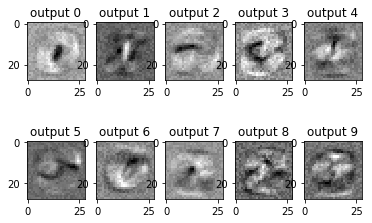

In [19]:
W1 = network.layers[0].get_weights()[0]
WW = W1.reshape(28,28,10)

plt.subplot(2,5,1)
plt.imshow(WW[:,:,0], cmap=plt.get_cmap('gray'))
plt.title('output 0')
plt.subplot(2,5,2)
plt.imshow(WW[:,:,1], cmap=plt.get_cmap('gray'))
plt.title('output 1')
plt.subplot(2,5,3)
plt.imshow(WW[:,:,2], cmap=plt.get_cmap('gray'))
plt.title('output 2')
plt.subplot(2,5,4)
plt.imshow(WW[:,:,3], cmap=plt.get_cmap('gray'))
plt.title('output 3')
plt.subplot(2,5,5)
plt.imshow(WW[:,:,4], cmap=plt.get_cmap('gray'))
plt.title('output 4')
plt.subplot(2,5,6)
plt.imshow(WW[:,:,5], cmap=plt.get_cmap('gray'))
plt.title('output 5')
plt.subplot(2,5,7)
plt.imshow(WW[:,:,6], cmap=plt.get_cmap('gray'))
plt.title('output 6')
plt.subplot(2,5,8)
plt.imshow(WW[:,:,7], cmap=plt.get_cmap('gray'))
plt.title('output 7')
plt.subplot(2,5,9)
plt.imshow(WW[:,:,8], cmap=plt.get_cmap('gray'))
plt.title('output 8')
plt.subplot(2,5,10)
plt.imshow(WW[:,:,9], cmap=plt.get_cmap('gray'))
plt.title('output 9')
# show the plot
plt.show()

Wat zie je wanneer je de 10 visualisaties bekijkt? Waarom laat iedere perceptron dit specifieke patroon zien?

__=====================================================================================================================__
<b><center>Pauzeer hier</center></b>
__=====================================================================================================================__

>_Extra: Door de onderstaande cel uit te voeren, wordt een iets geavanceerdere variant van het netwerk dat we net hebben gebouwd weergegeven. Experimenteer met het tekenen van cijfers, om te kijken of de vorm of positie invloed hebben op de voorspellingen van het netwerk._

In [ ]:
%%html
<iframe src="http://scs.ryerson.ca/~aharley/vis/fc/" width="990" height="550"></iframe>

Deze Jupyter notebook is gebaseerd op https://github.com/fchollet/deep-learning-with-python-notebooks.

# Einde sessie hier? Foto uploaden misschien te ingewikkeld

Nu het neurale netwerk getraind is, kunnen we voorspellingen gaan doen:

- Schrijf een nummer op, en maak er een foto van met je smartphone.


- Gebruik je smartphone om een vierkante uitsnede van de foto te maken.


- Upload de foto in de map waarin ook deze notebook staat.

Zodra je foto is geupload, kun je de onderstaande verwijzing onder de variabele `file` aanpassen, zodat deze dezelfde bestandsnaam heeft al de zojuist toegevoegde foto. Wanneer het niet lukt om een foto te maken kan gebruik gemaakt worden van een voorbeeldfoto -- voer dan `images/img.jpg` in als bestandsnaam:

In [ ]:
file = 'bestandsnaam-hier.jpg'

print('Bestandsnaam bijgewerkt.')

Wanneer alles goed is gegaan kunnen we de foto visualiseren:

In [ ]:
img = cv2.imread(file,0)
img = cv2.resize(img, (28, 28))
img = (255-img)
img = np.reshape(img, [1, 28 * 28])
plt.imshow(img[0].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show

Onze foto zou er nu min of meer hetzelfde uit moeten zien als de voorbeelden uit de train-dataset. Als laatste presenteren we de foto aan ons neurale netwerk, om een voorspelling te kunnen doen:

In [ ]:
print("Het op perceptrons gebaseerde neurale netwerk voorspelt:", (np.argmax(network.predict(img))))

Was de voorspelling juist?

__=====================================================================================================================__
<b><center>Stop Hier</center></b>
__=====================================================================================================================__

Kijk niet vreemd op wanneer het netwerk niet in staat was een juiste voorspelling te doen. De perceptrons die we tot nu toe hebben gebruikt zijn een van de simpelste vormen van neurale netwerken.

Laten we proberen om de afbeelding door een geavanceerder neuraal netwerk te halen. Om dit te doen moeten we de datasets opnieuw importeren en verwerken, een nieuw neuraal netwerk opzetten en het netwerk opnieuw trainen. Door de geavanceerde structuur van het onderstaande netwerk kan het langer duren om te trainen.

De theorie achter het type netwerk dat we nu gaan toepassen (een convolutional neuraal netwerk) valt buiten de scope van deze sessie.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

test_loss, test_acc = model.evaluate(test_images, test_labels)

print('test_acc:', test_acc)

Terwijl ons eerdere netwerk een nauwkeurigheidsscore van ongeveer 92% haalde, bereikt dit nieuwe netwerk een score van 99% !

Nu kunnen we opnieuw een voorspelling uitvoeren.

In [ ]:
img2 = cv2.imread(file,0)
img2 = cv2.resize(img2, (28, 28))
img2 = (255-img2)
img2 = np.reshape(img2, [1, 28, 28, 1])

print("Het geavanceerde neurale netwerk voorspelt:", (np.argmax(model.predict(img2))))